In [23]:
!chmod 600 /content/kaggle.json

In [24]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mahmoudreda55/satellite-image-classification

satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
import zipfile
zip_file = zipfile.ZipFile('/content/satellite-image-classification.zip')
zip_file.extractall('/tmp/')

In [26]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [27]:
import tensorflow as tf
tf.device('/device:GPU:0')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from PIL import Image
total = 0



In [28]:
import os

satellite_full_file = os.path.join('/tmp/data')

print(os.listdir(satellite_full_file))

['desert', 'cloudy', 'water', 'green_area']


In [29]:
list_sattelite = os.listdir(satellite_full_file)
print(list_sattelite)

['desert', 'cloudy', 'water', 'green_area']


In [30]:
for x in list_sattelite:
  dir = os.path.join(satellite_full_file, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

desert: 1131
- (256, 256)
- (256, 256)
- (256, 256)
- (256, 256)
---------------
cloudy: 1500
- (256, 256)
- (256, 256)
- (256, 256)
- (256, 256)
---------------
water: 1500
- (64, 64)
- (64, 64)
- (64, 64)
- (64, 64)
---------------
green_area: 1500
- (64, 64)
- (64, 64)
- (64, 64)
- (64, 64)
---------------

Total : 5631


<function matplotlib.pyplot.show(*args, **kw)>

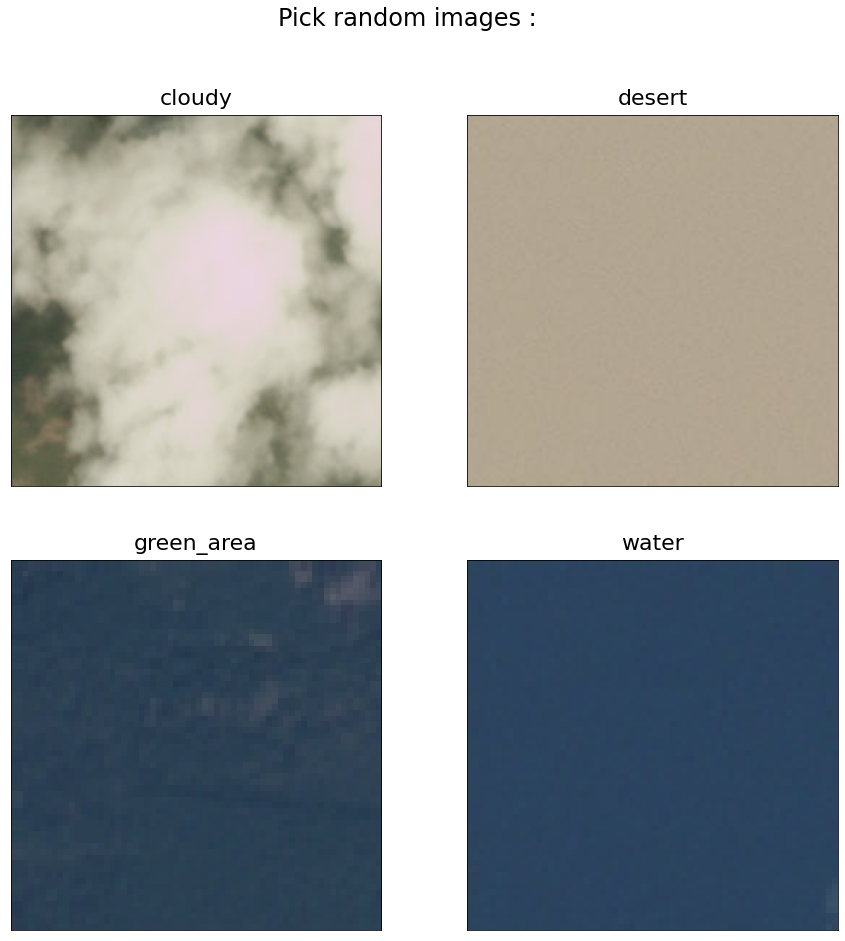

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Pick random images : ", fontsize=24)
satellite_sorted = sorted(list_sattelite)
satellite_id = 0
for i in range(2):
  for j in range(2):
    try:
      satellite_selected = satellite_sorted[satellite_id] 
      satellite_id += 1
    except:
      break
    if satellite_selected == '.TEMP':
        continue
    satellite_selected_images = os.listdir(os.path.join(satellite_full_file, satellite_selected))
    satellite_selected_random = np.random.choice(satellite_selected_images)
    img = plt.imread(os.path.join(satellite_full_file, satellite_selected, satellite_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(satellite_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [32]:
train_datagen_satellite = ImageDataGenerator(
    validation_split=0.2,   
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest',
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

In [33]:
batch_size = 128

data_train = train_datagen_satellite.flow_from_directory(
    satellite_full_file,
    target_size=(150, 150),
    batch_size = batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen_satellite.flow_from_directory(
    satellite_full_file, 
    target_size =(150, 150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation')

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [35]:
class historyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
      print("\n The Accuracy is up to > 95%, and forced to stop!")
      self.model.stop_training = True

callbacks = historyCallback()

In [36]:
history = model.fit(data_train, 
                    epochs = 200, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/200
35/35 [==============================] - 32s 892ms/step - loss: 0.7128 - accuracy: 0.6127 - val_loss: 0.4885 - val_accuracy: 0.7129
Epoch 2/200
35/35 [==============================] - 30s 872ms/step - loss: 0.4832 - accuracy: 0.7096 - val_loss: 0.6989 - val_accuracy: 0.5762
Epoch 3/200
35/35 [==============================] - 30s 853ms/step - loss: 0.5409 - accuracy: 0.6955 - val_loss: 0.5395 - val_accuracy: 0.6953
Epoch 4/200
35/35 [==============================] - 30s 857ms/step - loss: 0.4765 - accuracy: 0.7676 - val_loss: 0.4210 - val_accuracy: 0.7451
Epoch 5/200
35/35 [==============================] - 30s 852ms/step - loss: 0.3924 - accuracy: 0.8334 - val_loss: 0.3499 - val_accuracy: 0.8467
Epoch 6/200
35/35 [==============================] - 30s 851ms/step - loss: 0.3949 - accuracy: 0.8268 - val_loss: 0.3506 - val_accuracy: 0.8467
Epoch 7/200
35/35 [==============================] - 30s 857ms/step - loss: 0.3204 - accuracy: 0.8652 - val_loss: 0.3281 - val_accuracy:

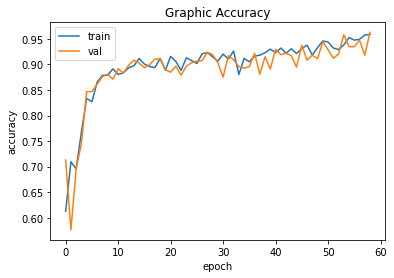

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Graphic Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

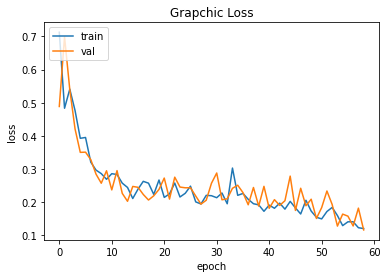

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grapchic Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)
